In [1]:
#Import libraries
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
import pickle

import warnings
warnings.filterwarnings('ignore')

**Columns Description** 
* **footfall:** The number of people or objects passing by the machine.
* **tempMode:** The temperature mode or setting of the machine.
* **AQ:** Air quality index near the machine.
* **USS:** Ultrasonic sensor data, indicating proximity measurements.
* **CS:** Current sensor readings, indicating the electrical current usage of the machine.
* **VOC:** Volatile organic compounds level detected near the machine.
* **RP:** Rotational position or RPM (revolutions per minute) of the machine parts.
* **IP:** Input pressure to the machine.
* **Temperature:** The operating temperature of the machine.
* **fail:** Binary indicator of machine failure (1 for failure, 0 for no failure).

In [2]:
#Load data
df = pd.read_csv('machine_fail.csv')

In [3]:
#Display data
df.head()

,footfall,tempMode,AQ,USS,CS,VOC,RP,IP,Temperature,fail,temp_diff,RP_Avg
0,0,7,7,1,6,6,36,3,1,1,6,-11
1,190,1,3,3,5,1,20,4,1,0,0,-27
2,31,7,2,2,6,1,24,6,1,0,6,-23
3,83,4,3,4,5,1,28,6,1,0,3,-19
4,640,7,5,6,4,0,68,6,1,0,6,21


In [4]:
#Function to get the summary
def get_summary(df):
    df_desc = pd.DataFrame(df.describe(include='all').transpose())
    df_summary = pd.DataFrame({
        'data type': df.dtypes,
        '#missing values': df.isnull().sum().values,
        '#duplicated values': df.duplicated().sum(),
        '#unique': df.nunique().values,
        'min': df_desc['min'].values,
        'max': df_desc['max'].values,
        'avg': df_desc['mean'].values,
        'std dev': df_desc['std'].values,
    })
    return df_summary.style.background_gradient(cmap='Accent_r')

In [5]:
get_summary(df)

,data type,#missing values,#duplicated values,#unique,min,max,avg,std dev
footfall,int64,0,0,99,0.000000,7300.000000,306.673383,1083.144024
tempMode,int64,0,0,8,0.000000,7.000000,3.726405,2.678334
AQ,int64,0,0,7,1.000000,7.000000,4.326617,1.438551
USS,int64,0,0,7,1.000000,7.000000,2.939555,1.384458
CS,int64,0,0,7,1.000000,7.000000,5.393425,1.269869
VOC,int64,0,0,7,0.000000,6.000000,2.844115,2.273751
RP,int64,0,0,71,19.000000,91.000000,47.042418,16.431816
IP,int64,0,0,7,1.000000,7.000000,4.564157,1.599452
Temperature,int64,0,0,24,1.000000,24.000000,16.326617,5.976014
fail,int64,0,0,2,0.000000,1.000000,0.416755,0.493283


In [6]:
#Remove duplicate values
df.drop_duplicates(keep='first',inplace=True)

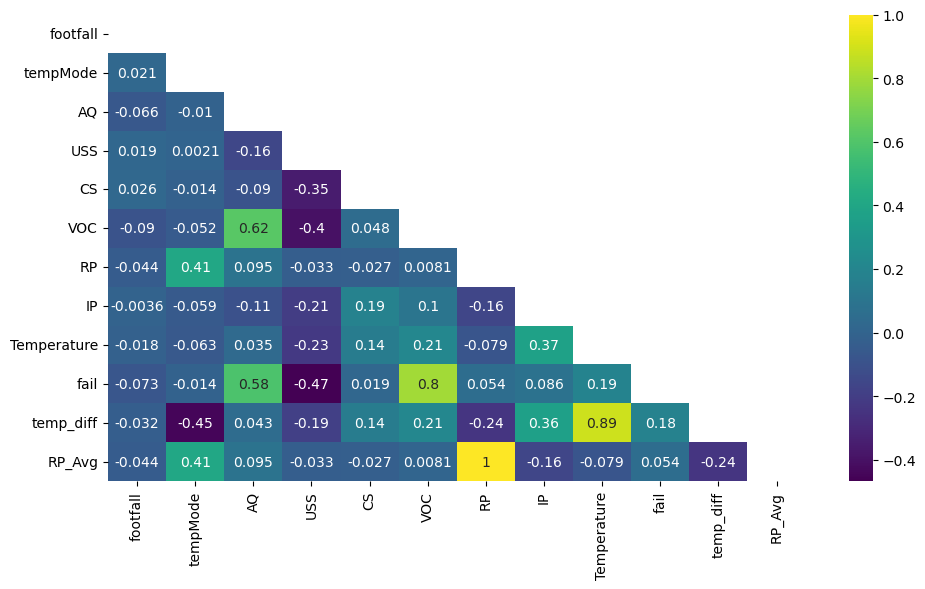

In [7]:
#Find correlations
mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(10,6))
sns.heatmap(df.corr(),annot=True,cmap='viridis',mask=mask)
plt.tight_layout()
plt.show()

In [8]:
for i, col in enumerate(df.columns.tolist()):
    print(i,col)

0 footfall
1 tempMode
2 AQ
3 USS
4 CS
5 VOC
6 RP
7 IP
8 Temperature
9 fail
10 temp_diff
11 RP_Avg


In [9]:
#Function to plot bar graphs
def bar_graph(data: pd.DataFrame):
    n = len(data.columns)
    fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
    ax = np.ravel(ax)
    for i, col in enumerate(data.columns.tolist()):
        if col == 'footfall' or col =='RP':
            sns.histplot(data=data, x = data[col],ax=ax[i-1],bins=14)
            ax[i].set_title('{} hist graph'.format(col))
        
        elif col == 'fail':
            pass
        else:
            sns.barplot(data=data, x=data[col], y=data['fail'], ax=ax[i-1],errorbar=('ci',10))
            ax[i-1].set_title('{} bar graph'.format(col))
            for p in ax[i-1].patches:
                ax[i-1].annotate(format(p.get_height(), '.2f'), 
                               (p.get_x() + p.get_width() / 2., p.get_height()), 
                               ha = 'center', va = 'center', 
                               xytext = (0, 9), 
                               textcoords = 'offset points')
    plt.delaxes()
    plt.tight_layout()  # Adjust subplots to fit into the figure area.
    plt.show()

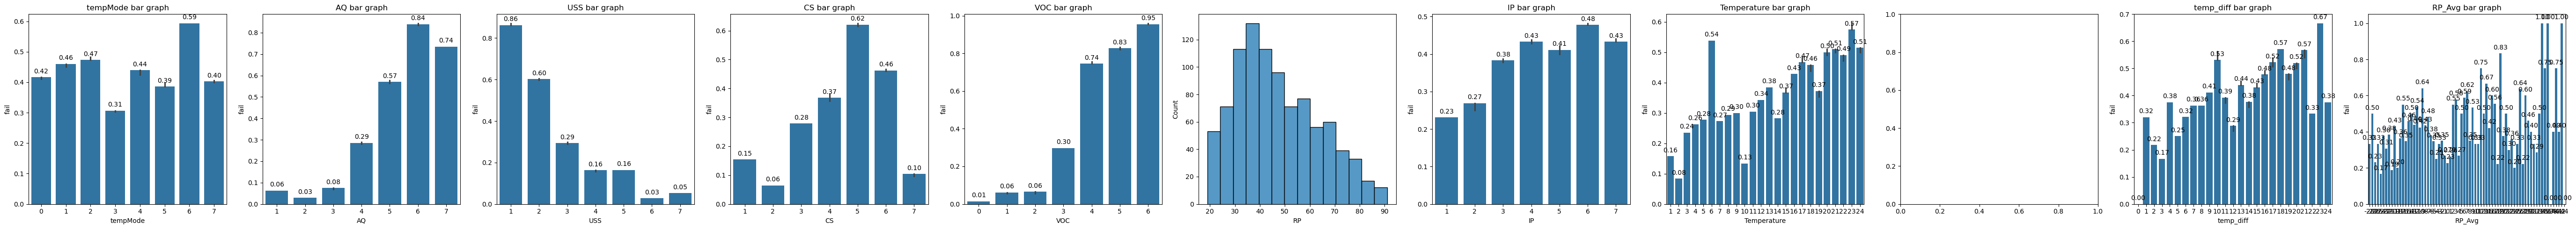

In [10]:
bar_graph(df)

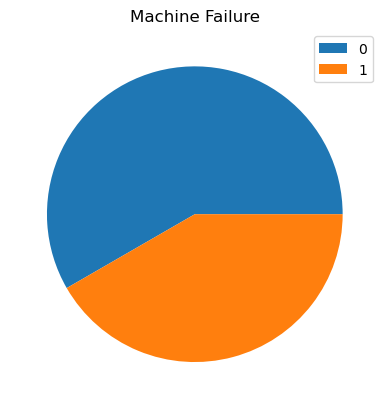

In [11]:
plt.pie(df['fail'].value_counts())
plt.title('Machine Failure')
plt.legend(df['fail'].value_counts().index)
plt.show()

In [12]:
#New features
df['temp_diff'] = np.abs(df['Temperature'] - df['tempMode'])
df['RP_Avg'] = np.round((df['RP'] - df['RP'].mean()))

In [13]:
#Split data into features and labels
X = df.drop('fail',axis=1)
y = df['fail']

seed = 10256

train_x, valid_x , train_y , valid_y = train_test_split(X,y, test_size = 0.2, stratify = y , random_state = seed)

In [14]:
train_x.shape , valid_x.shape

((754, 11), (189, 11))

In [15]:
## Classification using Random Forest Classifier
forest_clf = RandomForestClassifier(random_state=42)
y_scores = cross_val_score(forest_clf, train_x, train_y, scoring="accuracy", cv=10)

y_scores

array([0.90789474, 0.92105263, 0.90789474, 0.90789474, 0.89333333,
       0.90666667, 0.88      , 0.92      , 0.94666667, 0.90666667])

With the machine learning done, we are able to achieve accuracies between 88% and 92%. This reflects high accuracy.

But accuracy is not the best metric for this classifier. We want to know how many failed and were in fact predicted as faulty. This is why we use the precision metric

In [16]:
## Classification using Random Forest Classifier
forest_clf = RandomForestClassifier(random_state=42)
y_scores = cross_val_score(forest_clf, train_x, train_y, scoring="precision", cv=10)

np.sort(y_scores * 100)

array([82.35294118, 87.09677419, 87.87878788, 87.87878788, 87.87878788,
       90.        , 90.        , 90.625     , 90.90909091, 93.10344828])

The model achieved precisions between 82% and 93%. Which shows that the model can easily predict faulty machines. 

In [17]:
model = RandomForestClassifier(random_state = 42)
model.fit(train_x, train_y)

RandomForestClassifier(random_state=42)

In [18]:
prediction = model.predict(valid_x)

In [19]:
print (f'Precision Score: {round(precision_score(valid_y, prediction) * 100,2)}')

Precision Score: 90.91


The final result is a 90.9% precision which is perfect for deployment.

In [20]:
#Saving the model for later use

with open('model.pkl', 'wb') as file:
    pickle.dump(model,file)